In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

In [2]:
# Date conversion methods from different languages to a datetime object

# Date conversion from Polish Daylio format to a datetime object
def get_date_from_polish(year, day_month):
    day, month = day_month.split(' ')
    
    month_dict = {"stycznia": 1, "lutego": 2, "marca": 3, "kwietnia": 4, "maja": 5, "czerwca": 6, "lipca": 7,
                  "sierpnia": 8, "września": 9, "października": 10, "listopada": 11, "grudnia": 12}
    
    return date(int(year), month_dict.get(month), int(day))

# Date conversion from English Daylio format to a datetime object
def get_date_from_english(year, day_month):
    month, day = day_month.split(' ')
        
    month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8,
                  'September': 9, 'October': 10, 'November': 11, 'December': 12}

    return date( int(year), month_dict.get(month), int(day))

In [3]:
# Extract only the relevant data from the entry - year, date and rating.
def extract_data_from_row(row):
    return row[0], row[1], row[4]

In [4]:
# Conversion from regular data string in the format YYYY-MM-DD.
def convert_simply_into_date(string):
    year, month, day = string.split('-')
    return date(int(year), int(month), int(day))

In [5]:
lang_dict = {'pl': get_date_from_polish, 'en': get_date_from_english}

entries = []
events = {}
moods = {}
locale = 'pl'

# Read the moods
with open("moods.csv", encoding="utf-8") as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        description = row[0]
        value = float(row[1])
        lo = float(row[2])
        hi = float(row[3])
        color = row[4]
        moods[description] = value, lo, hi, color

# Read the entries
with open("daylio_export.csv", encoding="utf-8") as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        if "date" not in row:
            year, day_month, mood = extract_data_from_row(row)
            # entry_date = convert_into_date(year, day_month, locale='pl')
            entry_date = (lang_dict.get(locale))(year, day_month)
            mood_value = moods.get(mood)[0]
            entries.append(tuple([entry_date, mood_value]))

# Read events
with open("events.csv", encoding="utf=8") as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        event_date = convert_simply_into_date(row[0])
        event = row[1]
        events[event_date] = event
        
dates, ratings = zip(*entries)
dates = list(dates)
dates.reverse()
ratings = list(ratings)

In [7]:
# Methods for convolution kernels

# Returns a kernel with a given length and whose values are a reciprocal of this length (they sum up to 1)
def N_day_average_kernel(days):
    return [1/days for i in range(0, days)]

# Returns a kernel whose values are weighted according to the values passed by the user.
def custom_kernel(days_and_weights):
    result = []
    for days, weight in days_and_weights:
        for i in range(days):
            result = result + [weight/days]
    return result

# Returns the result of a single convolution (vector scalar product)
def single_convolution(data, kernel):
    result = 0
    for d, k in zip(data, kernel):
        result += d * k
    return result

# Returns a convoluted array.
def convolute(data, kernel):
    kernel_length = len(kernel)
    result = []
    
    for i in range(kernel_length, len(data)):
        data_slice = data[i-kernel_length+1 : i+1]
        temp_result = single_convolution(data_slice, kernel)
        result += [temp_result]
    
    return result

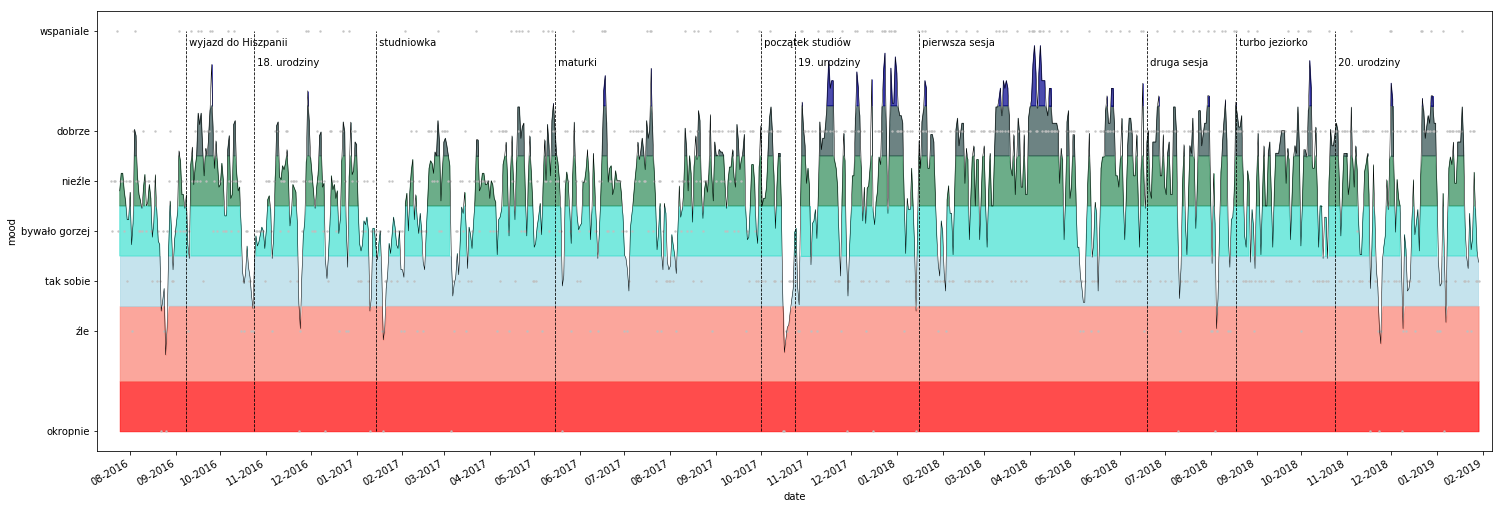

In [27]:
# Get plots
fig, axes = plt.subplots(figsize=(25, 9))

# Marigns are a little to wide.
axes.set_xmargin(0.01)

# Set axis labels
axes.set_xlabel("date")
axes.set_ylabel("mood")

# Months on the x axis
axes.xaxis.set_major_locator(mdates.MonthLocator())
axes.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))

# Moods and values on the y axis
axes.set_yticks([value[0] for value in moods.values()])
axes.set_yticklabels([*moods.keys()])

# Plot unedited ratings
axes.plot_date(dates, ratings, markersize=3, color = 'silver', alpha=0.75, marker='.')

# Get yourself a kernel and edited ratings
kernel = custom_kernel([(4, 0.3), (2, 0.7)])
kernel_size = len(kernel)
smooth_ratings = convolute(ratings, kernel)

#Plot edited ratings
axes.plot_date(dates[kernel_size:], smooth_ratings, linestyle='-', color='black', linewidth=0.5, markersize=0)

# Plot event lines
for key, value, counter in zip(events.keys(), events.values(), range(len(events))):
    # I don't know how to rotate the text, so I'll just switch between heights
    odd = counter % 2
    axes.vlines(key, 1, 5, label=value, linewidths=0.8, linestyles='dashed')
    axes.annotate(value, xy=(mdates.date2num(key), 4.85 - odd*0.2))

# Do the fancy fill
for value, lo, hi, color in moods.values():
    axes.fill_between(dates[kernel_size:],
                      lo,
                      [min(hi, smooth_ratings[i]) for i in range(len(smooth_ratings))],
                where=[smooth_ratings[i] >= lo for i in range(len(smooth_ratings))],
                alpha=0.7,
                color=color)

# Autoformat the dates nicely
fig.autofmt_xdate()